Calculate correlation between features and the label (Total_Returns_NextYear).
Keep only the top 5 most correlated features 
SPLIT USING split_time_series_by_river

THIRD APPROACH
TOP_5FEATURES
RIVER ALAGNAK

GradientBoostingRegressor

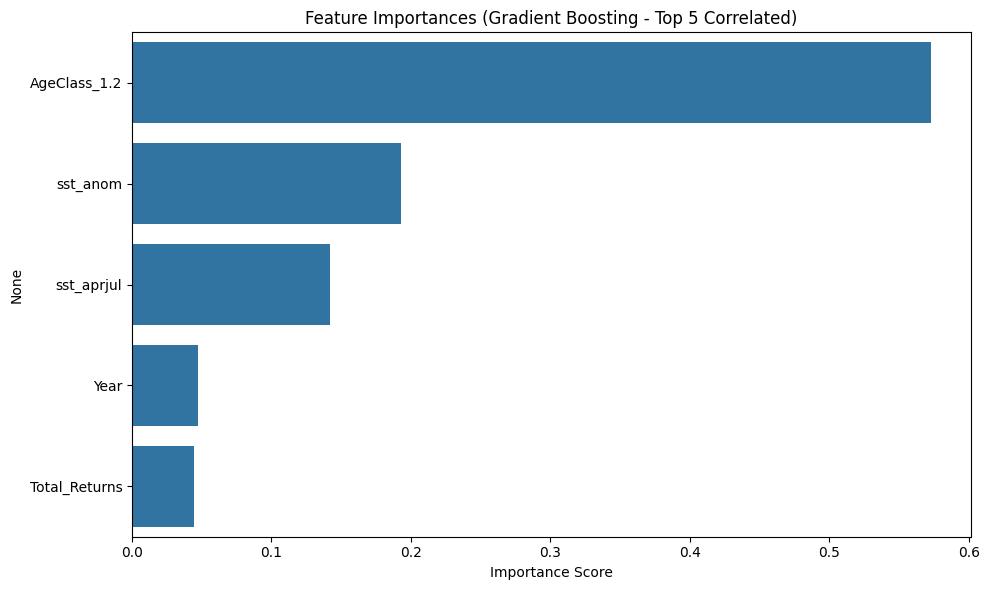

📊 Gradient Boosting Evaluation (Alagnak - Top 5 Features):
THIRD APPROACH - River Alagnak - TOP 5 FEATURES
🔹 R²   (train): 1.0000     | R²   (test): -3.7741
🔹 MSE  (train):  2122806.51   | MSE  (test):  8052370007648.39
🔹 MAPE (train): 0.07%  | MAPE (test): 82.14%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 5 correlated features ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top5_features = target_corr.abs().sort_values(ascending=False).head(5).index.tolist()
columns_to_keep = top5_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    columns_to_keep.append('Year')
df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Split time-series ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()
    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)
    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak, time_column="Year", group_columns=["River"], test_fraction=0.2, gap_years=0
)

# === Step 4: Prepare features and target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train = data_train['Total_Returns_NextYear']
X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']

# === Step 5: Train model ===
gbr = GradientBoostingRegressor(
    n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42
)
gbr.fit(X_train, y_train)

# === Step 6: Plot feature importances ===
feature_importances = pd.Series(gbr.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Gradient Boosting - Top 5 Correlated)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Evaluate ===
y_pred_train = gbr.predict(X_train)
y_pred_test = gbr.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("📊 Gradient Boosting Evaluation (Alagnak - Top 5 Features):")
print("THIRD APPROACH - River Alagnak - TOP 5 FEATURES")
print(f"🔹 R²   (train): {r2_train:.4f}     | R²   (test): {r2_test:.4f}")
print(f"🔹 MSE  (train):  {mse_train:.2f}   | MSE  (test):  {mse_test:.2f}")
print(f"🔹 MAPE (train): {mape_train:.2f}%  | MAPE (test): {mape_test:.2f}%")

# Define result string
result_str = (
    "\n\n===============================\n"
    "THIRD APPROACH - TOP 5 FEATURES - Alagnak Only\n"
    "Gradient Boosting Evaluation Metrics:\n"
    f"R²   (R-squared test):          {r2_test:.4f}\n"
    f"R²   (R-squared train):         {r2_train:.4f}\n"
    f"MSE  (Mean Squared Erro train):      {mse_train:.2f}\n"
    f"MSE  (Mean Squared Error test):      {mse_test:.2f}\n"
    f"MAPE (MAPE train):   {mape_train:.2f}%\n"
    f"MSE  (MAPE test):      {mape_test:.2f}\n"
)

# Path to results file
results_path = r"C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\results.txt"

# Append to file
with open(results_path, "a", encoding="utf-8") as f:
    f.write(result_str)


Polynomial Regression

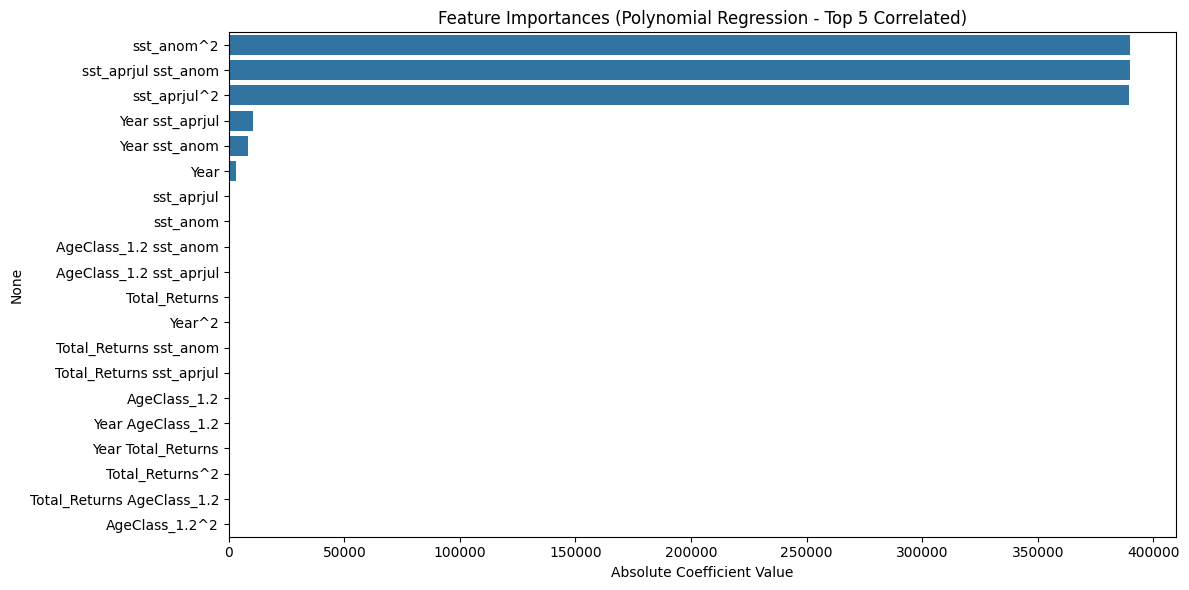

📊 Polynomial Regression Evaluation (Alagnak - Top 5 Features):
THIRD APPROACH - River Alagnak - TOP 5 FEATURES
🔹 R²   (train): 0.7798     | R²   (test): -41.7728
🔹 MSE  (train):  755283357197.73   | MSE  (test):  72144516957896.59
🔹 MAPE (train): 34.71%  | MAPE (test): 199.48%


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 5 correlated features ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top5_features = target_corr.abs().sort_values(ascending=False).head(5).index.tolist()

columns_to_keep = top5_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Time-series split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()
    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)
    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak, time_column="Year", group_columns=["River"], test_fraction=0.2, gap_years=0
)

# === Step 4: Prepare features ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train = data_train['Total_Returns_NextYear']
X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']

# === Step 5: Polynomial transformation ===
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
feature_names = poly.get_feature_names_out(X_train.columns)

# === Step 6: Train model ===
model = LinearRegression()
model.fit(X_train_poly, y_train)

# === Step 7: Plot coefficients ===
coefficients = pd.Series(model.coef_, index=feature_names)
top_features = coefficients.abs().sort_values(ascending=False)

plt.figure(figsize=(12, max(6, len(top_features) * 0.25)))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Polynomial Regression - Top 5 Correlated)")
plt.xlabel("Absolute Coefficient Value")
plt.tight_layout()
plt.show()

# === Step 8: Predict & evaluate both train and test ===
y_pred_train = model.predict(X_train_poly)
y_pred_test = model.predict(X_test_poly)

r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# === Step 9: Print metrics ===
print("📊 Polynomial Regression Evaluation (Alagnak - Top 5 Features):")
print("THIRD APPROACH - River Alagnak - TOP 5 FEATURES")
print(f"🔹 R²   (train): {r2_train:.4f}     | R²   (test): {r2_test:.4f}")
print(f"🔹 MSE  (train):  {mse_train:.2f}   | MSE  (test):  {mse_test:.2f}")
print(f"🔹 MAPE (train): {mape_train:.2f}%  | MAPE (test): {mape_test:.2f}%")

# Define result string
result_str = (
    "\n\n===============================\n"
    "THIRD APPROACH - TOP 5 FEATURES - Alagnak Only\n"
    "Polynomial Regression Evaluation:\n"
    f"R²   (R-squared test):          {r2_test:.4f}\n"
    f"R²   (R-squared train):         {r2_train:.4f}\n"
    f"MSE  (Mean Squared Erro train):      {mse_train:.2f}\n"
    f"MSE  (Mean Squared Error test):      {mse_test:.2f}\n"
    f"MAPE (MAPE train):   {mape_train:.2f}%\n"
    f"MSE  (MAPE test):      {mape_test:.2f}\n"
)

# Path to results file
results_path = r"C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\results.txt"

# Append to file
with open(results_path, "a", encoding="utf-8") as f:
    f.write(result_str)



Linear Regression

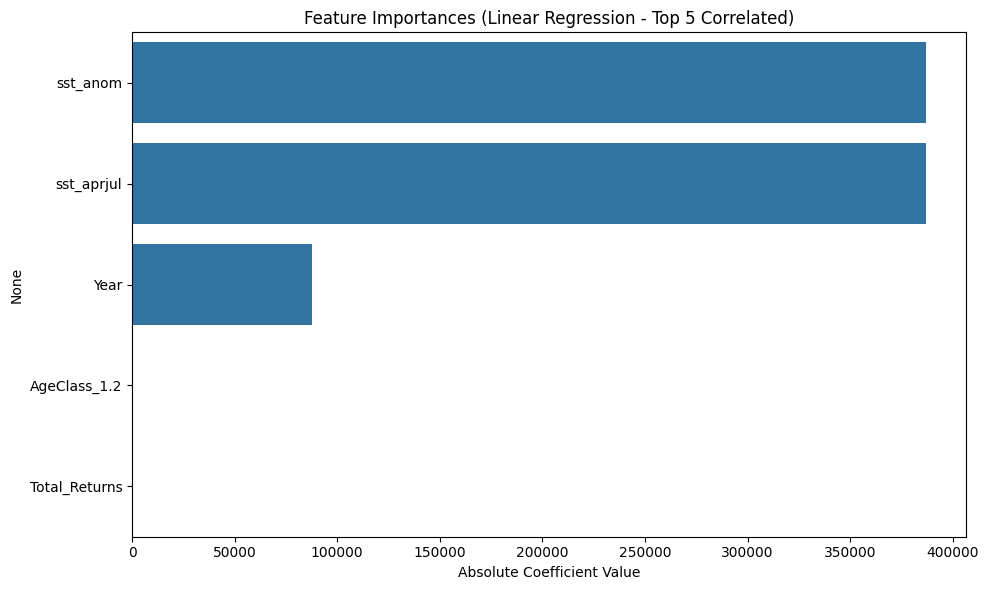

📊 Linear Regression Evaluation (Alagnak - Top 5 Features):
THIRD APPROACH - River Alagnak - TOP 5 FEATURES
🔹 R²   (train): 0.5437     | R²   (test): -1.5759
🔹 MSE  (train):  1564930613616.54   | MSE  (test):  4344812107847.04
🔹 MAPE (train): 45.79%  | MAPE (test): 62.18%


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 5 correlated features ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top5_features = target_corr.abs().sort_values(ascending=False).head(5).index.tolist()

columns_to_keep = top5_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Split time-series ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()
    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)
    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak, time_column="Year", group_columns=["River"], test_fraction=0.2, gap_years=0
)

# === Step 4: Prepare features/target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train = data_train['Total_Returns_NextYear']
X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']

# === Step 5: Train model ===
model = LinearRegression()
model.fit(X_train, y_train)

# === Step 6: Coefficient plot ===
coefficients = pd.Series(model.coef_, index=X_train.columns)
top_features = coefficients.abs().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Linear Regression - Top 5 Correlated)")
plt.xlabel("Absolute Coefficient Value")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Evaluate (Train/Test) ===
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# === Step 8: Print metrics ===
print("📊 Linear Regression Evaluation (Alagnak - Top 5 Features):")
print("THIRD APPROACH - River Alagnak - TOP 5 FEATURES")
print(f"🔹 R²   (train): {r2_train:.4f}     | R²   (test): {r2_test:.4f}")
print(f"🔹 MSE  (train):  {mse_train:.2f}   | MSE  (test):  {mse_test:.2f}")
print(f"🔹 MAPE (train): {mape_train:.2f}%  | MAPE (test): {mape_test:.2f}%")

# Define result string
result_str = (
    "\n\n===============================\n"
    "THIRD APPROACH - TOP 5 FEATURES - Alagnak Only\n"
    "Linear Regression Evaluation:\n"
    f"R²   (R-squared test):          {r2_test:.4f}\n"
    f"R²   (R-squared train):         {r2_train:.4f}\n"
    f"MSE  (Mean Squared Erro train):      {mse_train:.2f}\n"
    f"MSE  (Mean Squared Error test):      {mse_test:.2f}\n"
    f"MAPE (MAPE train):   {mape_train:.2f}%\n"
    f"MSE  (MAPE test):      {mape_test:.2f}\n"
)

# Path to results file
results_path = r"C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\results.txt"

# Append to file
with open(results_path, "a", encoding="utf-8") as f:
    f.write(result_str)


Random Forest model

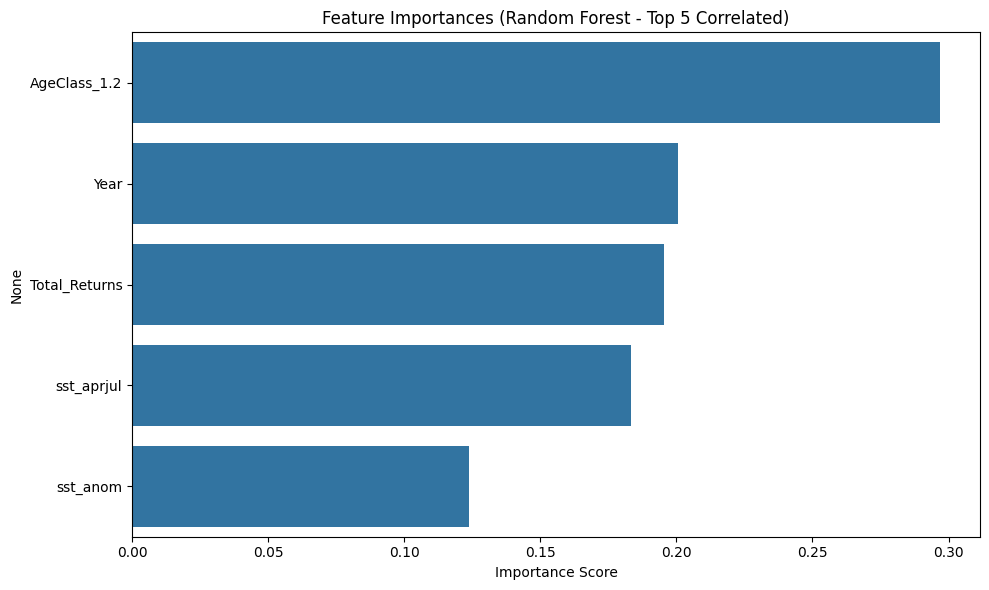

📊 Random Forest Evaluation (Alagnak - Top 5 Features):
THIRD APPROACH - River Alagnak - TOP 5 FEATURES
🔹 R²   (train): 0.9078     | R²   (test): -1.2750
🔹 MSE  (train):  316226300859.37   | MSE  (test):  3837232598785.69
🔹 MAPE (train): 18.91%  | MAPE (test): 58.23%


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 5 correlated features ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top5_features = target_corr.abs().sort_values(ascending=False).head(5).index.tolist()

columns_to_keep = top5_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Time-series split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()
    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)
    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak, time_column="Year", group_columns=["River"], test_fraction=0.2, gap_years=0
)

# === Step 4: Prepare features/target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train = data_train['Total_Returns_NextYear']
X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']

# === Step 5: Train model ===
rf = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42)
rf.fit(X_train, y_train)

# === Step 6: Feature importances ===
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Random Forest - Top 5 Correlated)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Evaluate (train + test) ===
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# === Step 8: Print results ===
print("📊 Random Forest Evaluation (Alagnak - Top 5 Features):")
print("THIRD APPROACH - River Alagnak - TOP 5 FEATURES")
print(f"🔹 R²   (train): {r2_train:.4f}     | R²   (test): {r2_test:.4f}")
print(f"🔹 MSE  (train):  {mse_train:.2f}   | MSE  (test):  {mse_test:.2f}")
print(f"🔹 MAPE (train): {mape_train:.2f}%  | MAPE (test): {mape_test:.2f}%")

# Define result string
result_str = (
    "\n\n===============================\n"
    "THIRD APPROACH - TOP 5 FEATURES - Alagnak Only\n"
    "Random Forest:\n"
    f"R²   (R-squared test):          {r2_test:.4f}\n"
    f"R²   (R-squared train):         {r2_train:.4f}\n"
    f"MSE  (Mean Squared Erro train):      {mse_train:.2f}\n"
    f"MSE  (Mean Squared Error test):      {mse_test:.2f}\n"
    f"MAPE (MAPE train):   {mape_train:.2f}%\n"
    f"MSE  (MAPE test):      {mape_test:.2f}\n"
)

# Path to results file
results_path = r"C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\results.txt"

# Append to file
with open(results_path, "a", encoding="utf-8") as f:
    f.write(result_str)


Random Forest Updated Code with Log Transform on Target

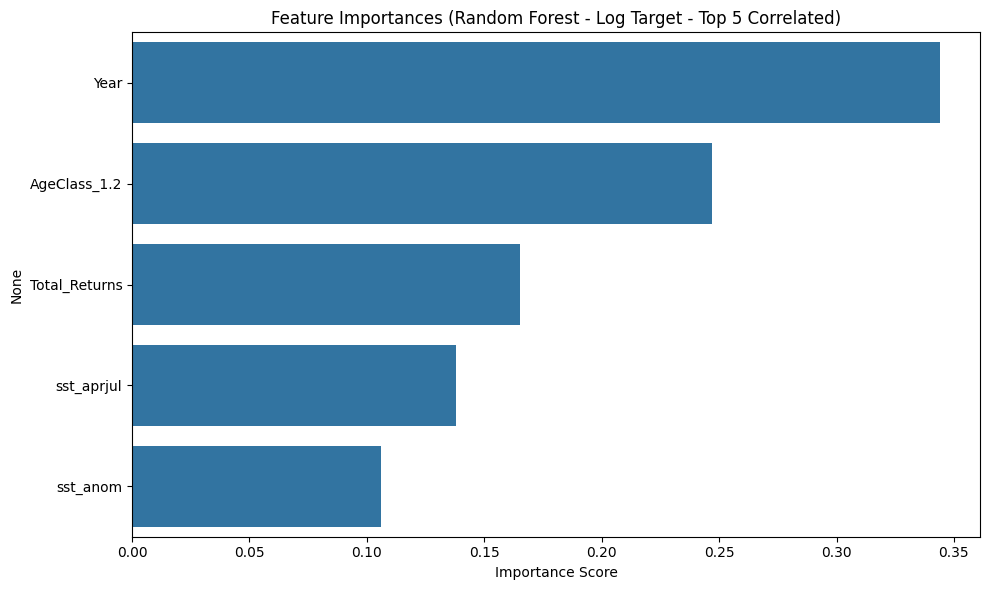

📊 Random Forest (Log Target, Alagnak - Top 5 Features):
THIRD APPROACH - River Alagnak - TOP 5 FEATURES
🔹 R²   (train): 0.8840     | R²   (test): -0.9710
🔹 MSE  (train):  397757731894.56   | MSE  (test):  3324487583836.07
🔹 MAPE (train): 13.72%  | MAPE (test): 54.17%


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 5 correlated features ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top5_features = target_corr.abs().sort_values(ascending=False).head(5).index.tolist()

columns_to_keep = top5_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Time-series split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()
    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)
    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak, time_column="Year", group_columns=["River"], test_fraction=0.2, gap_years=0
)

# === Step 4: Prepare features and log-transformed target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train_log = np.log1p(data_train['Total_Returns_NextYear'])
X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']

# === Step 5: Train model ===
rf = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42)
rf.fit(X_train, y_train_log)

# === Step 6: Feature importances ===
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Random Forest - Log Target - Top 5 Correlated)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 7: Predict (train & test) and inverse log ===
y_pred_train_log = rf.predict(X_train)
y_pred_train = np.expm1(y_pred_train_log)

y_pred_test_log = rf.predict(X_test)
y_pred_test = np.expm1(y_pred_test_log)

y_train_real = data_train['Total_Returns_NextYear']  # original scale

# === Step 8: Evaluation ===
r2_train = r2_score(y_train_real, y_pred_train)
mse_train = mean_squared_error(y_train_real, y_pred_train)
mape_train = np.mean(np.abs((y_train_real - y_pred_train) / y_train_real)) * 100

r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# === Step 9: Print results ===
print("📊 Random Forest (Log Target, Alagnak - Top 5 Features):")
print("THIRD APPROACH - River Alagnak - TOP 5 FEATURES")
print(f"🔹 R²   (train): {r2_train:.4f}     | R²   (test): {r2_test:.4f}")
print(f"🔹 MSE  (train):  {mse_train:.2f}   | MSE  (test):  {mse_test:.2f}")
print(f"🔹 MAPE (train): {mape_train:.2f}%  | MAPE (test): {mape_test:.2f}%")

# Define result string
result_str = (
    "\n\n===============================\n"
    "THIRD APPROACH - TOP 5 FEATURES - Alagnak Only\n"
    "Random Forest  Log Target:\n"
    f"R²   (R-squared test):          {r2_test:.4f}\n"
    f"R²   (R-squared train):         {r2_train:.4f}\n"
    f"MSE  (Mean Squared Erro train):      {mse_train:.2f}\n"
    f"MSE  (Mean Squared Error test):      {mse_test:.2f}\n"
    f"MAPE (MAPE train):   {mape_train:.2f}%\n"
    f"MSE  (MAPE test):      {mape_test:.2f}\n"
)

# Path to results file
results_path = r"C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\results.txt"

# Append to file
with open(results_path, "a", encoding="utf-8") as f:
    f.write(result_str)


 Random Forest + Log-Transform + GridSearchCV (Alagnak only):

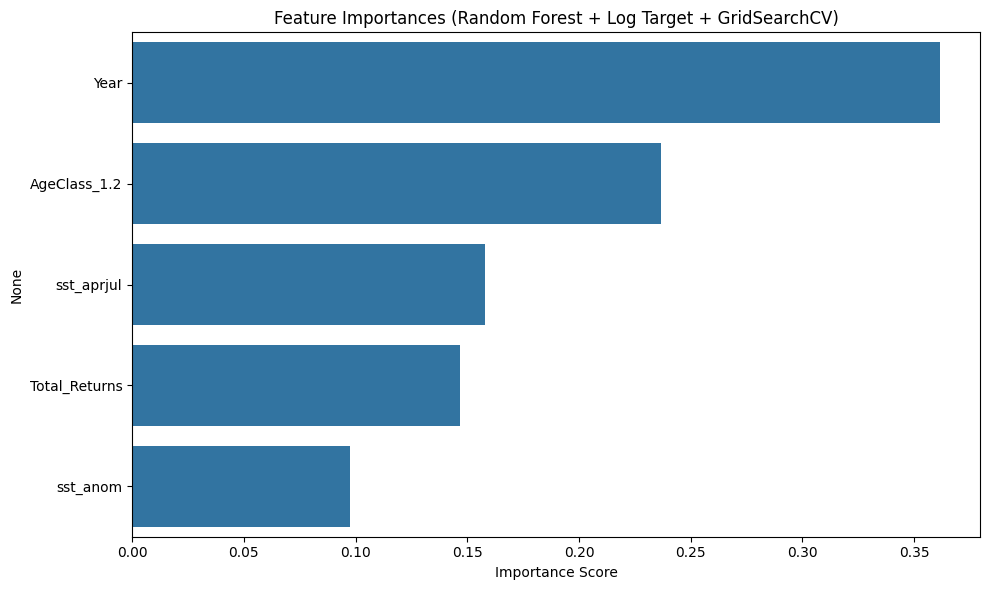

📊 Random Forest + Log-Transformed Target + GridSearchCV (Alagnak, Top 5 Features):
THIRD APPROACH - River Alagnak - TOP 5 FEATURES
Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
🔹 R²   (train): 0.8105     | R²   (test): -0.7854
🔹 MSE  (train):  649831816047.50   | MSE  (test):  3011438875529.23
🔹 MAPE (train): 17.14%  | MAPE (test): 50.99%


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Top 5 correlated features with target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top5_features = target_corr.abs().sort_values(ascending=False).head(5).index.tolist()

columns_to_keep = top5_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Time-series split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()
    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)
    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak, time_column="Year", group_columns=["River"], test_fraction=0.2, gap_years=0
)

# === Step 4: Prepare features and log-transformed target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train_log = np.log1p(data_train['Total_Returns_NextYear'])
X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']
y_train_real = data_train['Total_Returns_NextYear']  # for reverse evaluation

# === Step 5: GridSearchCV ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid.fit(X_train, y_train_log)
best_rf = grid.best_estimator_

# === Step 6: Feature importances ===
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Random Forest + Log Target + GridSearchCV)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 7: Predict and inverse log ===
y_pred_train_log = best_rf.predict(X_train)
y_pred_train = np.expm1(y_pred_train_log)

y_pred_test_log = best_rf.predict(X_test)
y_pred_test = np.expm1(y_pred_test_log)

# === Step 8: Evaluate ===
r2_train = r2_score(y_train_real, y_pred_train)
mse_train = mean_squared_error(y_train_real, y_pred_train)
mape_train = np.mean(np.abs((y_train_real - y_pred_train) / y_train_real)) * 100

r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# === Step 9: Print metrics ===
print("📊 Random Forest + Log-Transformed Target + GridSearchCV (Alagnak, Top 5 Features):")
print("THIRD APPROACH - River Alagnak - TOP 5 FEATURES")
print(f"Best Params: {grid.best_params_}")
print(f"🔹 R²   (train): {r2_train:.4f}     | R²   (test): {r2_test:.4f}")
print(f"🔹 MSE  (train):  {mse_train:.2f}   | MSE  (test):  {mse_test:.2f}")
print(f"🔹 MAPE (train): {mape_train:.2f}%  | MAPE (test): {mape_test:.2f}%")

# Define result string
result_str = (
    "\n\n===============================\n"
    "THIRD APPROACH - TOP 5 FEATURES - Alagnak Only\n"
    "Random Forest + Log-Transformed Target + GridSearchCV :\n"
    f"R²   (R-squared test):          {r2_test:.4f}\n"
    f"R²   (R-squared train):         {r2_train:.4f}\n"
    f"MSE  (Mean Squared Erro train):      {mse_train:.2f}\n"
    f"MSE  (Mean Squared Error test):      {mse_test:.2f}\n"
    f"MAPE (MAPE train):   {mape_train:.2f}%\n"
    f"MSE  (MAPE test):      {mape_test:.2f}\n"
)

# Path to results file
results_path = r"C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\results.txt"

# Append to file
with open(results_path, "a", encoding="utf-8") as f:
    f.write(result_str)

XGBoost Regressor

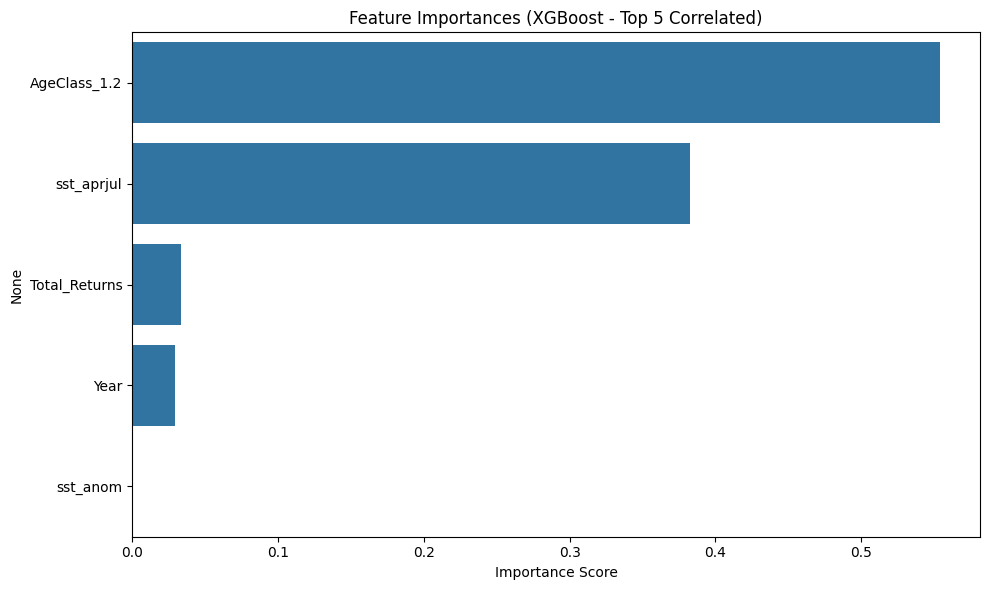

📊 XGBoost Evaluation Metrics (Alagnak, Top 5 Features):
THIRD APPROACH - River Alagnak - TOP 5 FEATURES
🔹 R²   (train): 1.0000     | R²   (test): -3.6951
🔹 MSE  (train):  0.29   | MSE  (test):  7919204683572.06
🔹 MAPE (train): 0.00%  | MAPE (test): 82.17%


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 5 correlated features ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top5_features = target_corr.abs().sort_values(ascending=False).head(5).index.tolist()

columns_to_keep = top5_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Split function ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train, data_test = pd.DataFrame(), pd.DataFrame()
    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)
    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak, time_column="Year", group_columns=["River"], test_fraction=0.2, gap_years=0
)

# === Step 4: Prepare features and target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    drop_columns.append('Year')

X_train = data_train.drop(columns=drop_columns)
y_train = data_train['Total_Returns_NextYear']
X_test = data_test.drop(columns=drop_columns)
y_test = data_test['Total_Returns_NextYear']

# === Step 5: Train XGBoost ===
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# === Step 6: Feature Importances Plot ===
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (XGBoost - Top 5 Correlated)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 7: Predict and Evaluate ===
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# === Step 8: Print metrics ===
print("📊 XGBoost Evaluation Metrics (Alagnak, Top 5 Features):")
print("THIRD APPROACH - River Alagnak - TOP 5 FEATURES")
print(f"🔹 R²   (train): {r2_train:.4f}     | R²   (test): {r2_test:.4f}")
print(f"🔹 MSE  (train):  {mse_train:.2f}   | MSE  (test):  {mse_test:.2f}")
print(f"🔹 MAPE (train): {mape_train:.2f}%  | MAPE (test): {mape_test:.2f}%")

# Define result string
result_str = (
    "\n\n===============================\n"
    "THIRD APPROACH - TOP 5 FEATURES - Alagnak Only\n"
    "XGBoost :\n"
    f"R²   (R-squared test):          {r2_test:.4f}\n"
    f"R²   (R-squared train):         {r2_train:.4f}\n"
    f"MSE  (Mean Squared Erro train):      {mse_train:.2f}\n"
    f"MSE  (Mean Squared Error test):      {mse_test:.2f}\n"
    f"MAPE (MAPE train):   {mape_train:.2f}%\n"
    f"MSE  (MAPE test):      {mape_test:.2f}\n"
)

# Path to results file
results_path = r"C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\results.txt"

# Append to file
with open(results_path, "a", encoding="utf-8") as f:
    f.write(result_str)
